In [1]:
from google.colab import files
uploaded = files.upload()

Saving NASA_Exoplanet_Archive_Cleaned.csv to NASA_Exoplanet_Archive_Cleaned.csv


--- Data Acquisition and Initial Preprocessing ---
Data loaded successfully from NASA_Exoplanet_Archive_Cleaned.csv. Initial count: 5983 planets.
Initial filter applied: Excluded 2977 planets with radius > 10.0 R_earth (unequivocal gas giants/brown dwarfs). Remaining: 3006 planets.

--- Preprocessing for Derived Parameters ---
Missing stellar luminosity calculated from stellar radius and effective temperature.
Missing semi-major axis calculated using Kepler's Third Law.
Missing stellar insolation calculated from stellar luminosity and semi-major axis.
M-dwarf stars identified for tidal locking assessment and assumed tidally locked.
Gas giant status (Yes/No/Unknown) determined.

--- Calculating Individual Habitability Scores ---
Individual feature scores (S_radius, S_flux, S_tidal, S_mass, S_temperature) calculated, returning NaN for missing data.

--- Calculating Total Habitability Score ---
Total habitability scores calculated with adaptive weighting, revised disqualification rules, a

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Download complete! 🎉

--- Generating All Requested Plots ---
Generating Spearman Correlation Matrix...


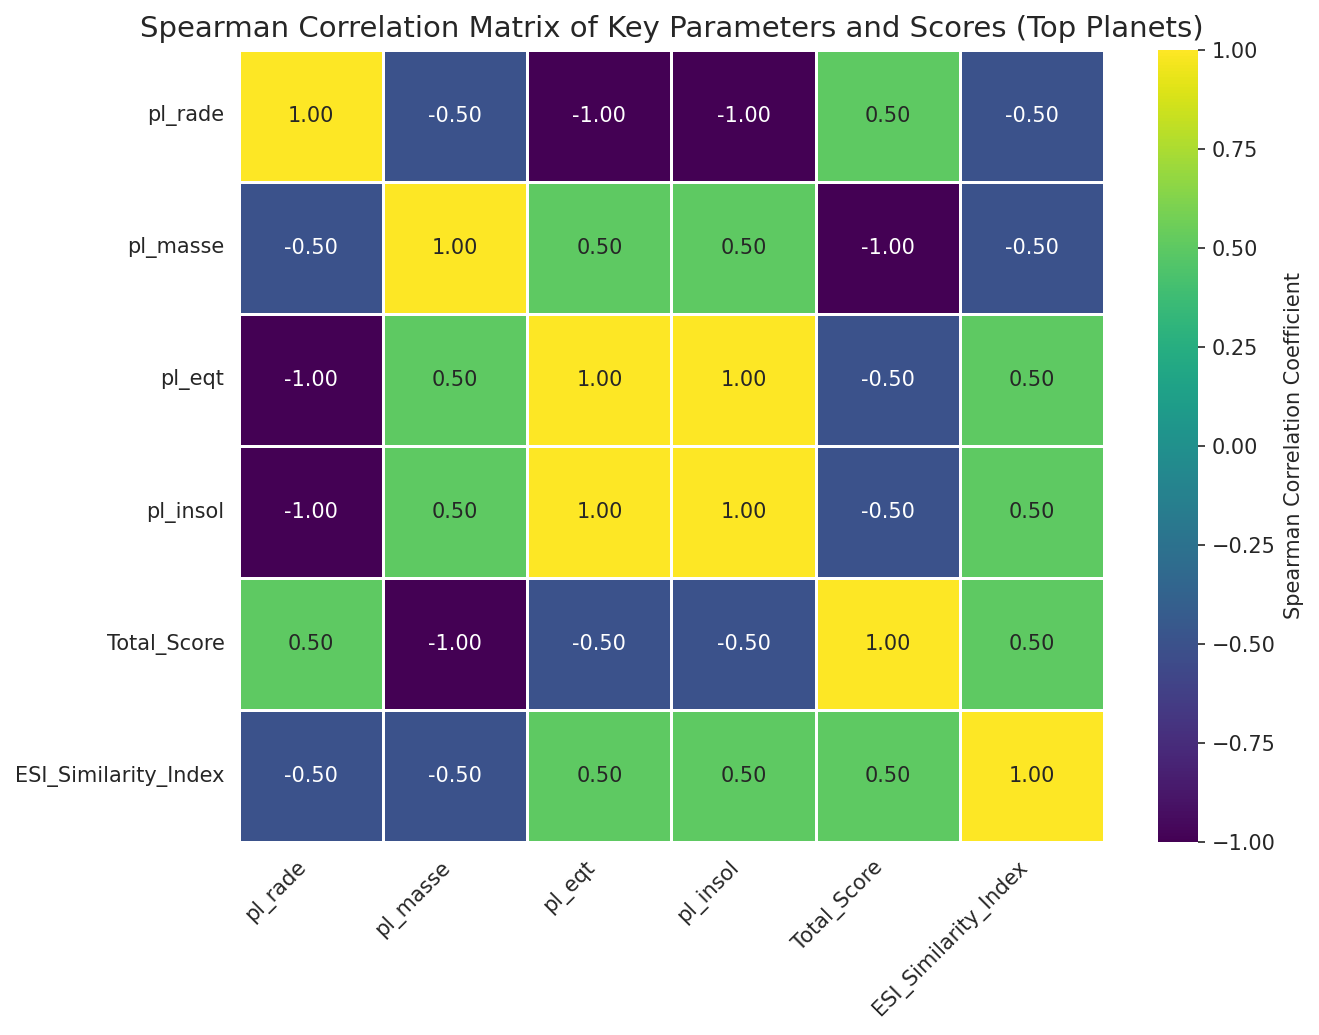


--- Spearman Correlation P-values (Top Planets) ---
                      pl_rade  pl_masse  pl_eqt  pl_insol  Total_Score  ESI_Similarity_Index
pl_rade                   1.0      -0.5    -1.0      -1.0          0.5                  -0.5
pl_masse                 -0.5       1.0     0.5       0.5         -1.0                  -0.5
pl_eqt                   -1.0       0.5     1.0       1.0         -0.5                   0.5
pl_insol                 -1.0       0.5     1.0       1.0         -0.5                   0.5
Total_Score               0.5      -1.0    -0.5      -0.5          1.0                   0.5
ESI_Similarity_Index     -0.5      -0.5     0.5       0.5          0.5                   1.0

Generating Total Habitability Score vs. Equilibrium Temperature scatter plot...


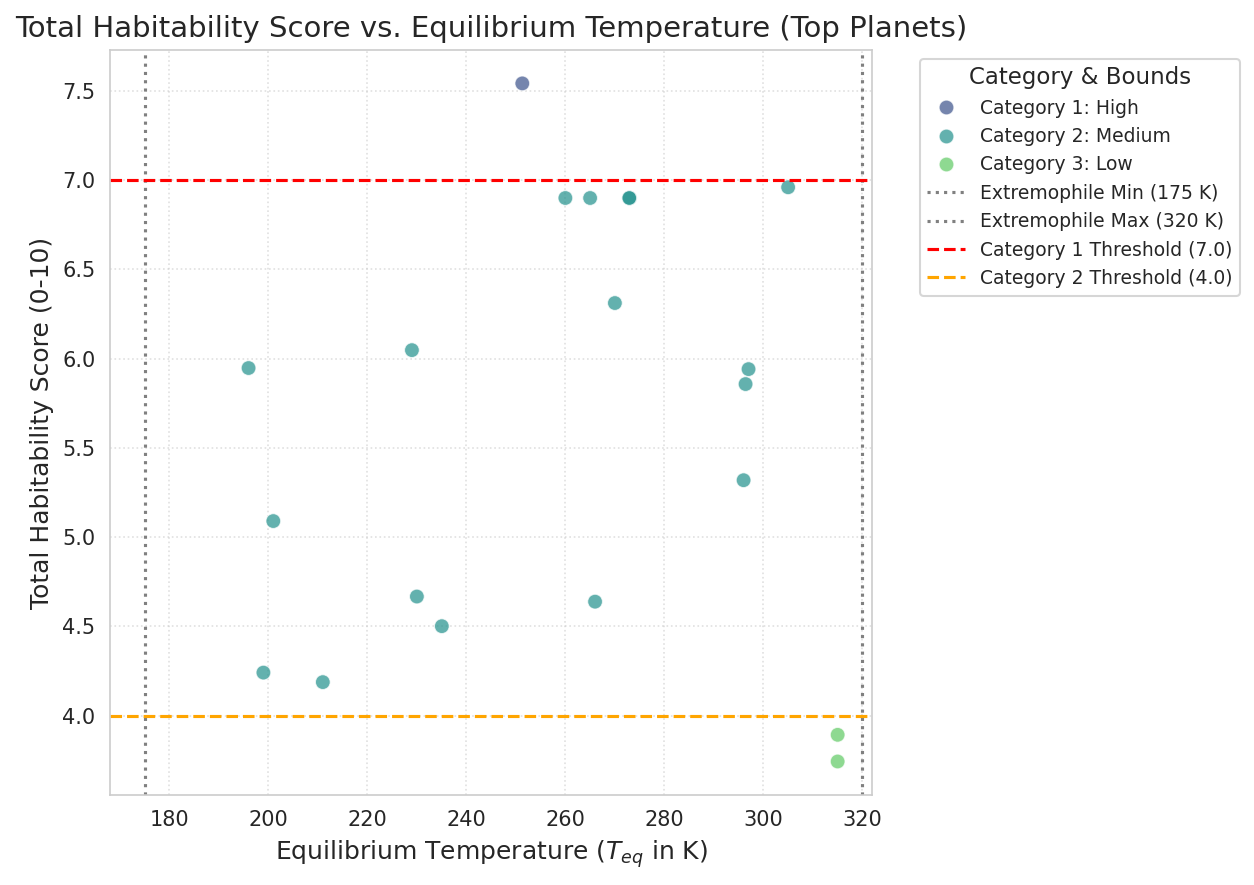


Generating Distribution of Habitability Categories bar plot...


/tmp/ipython-input-3287696095.py:516: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=top_planets, x='Habitability_Category', palette='viridis', order=category_order, edgecolor='black', linewidth=0.5) # Use top_planets here


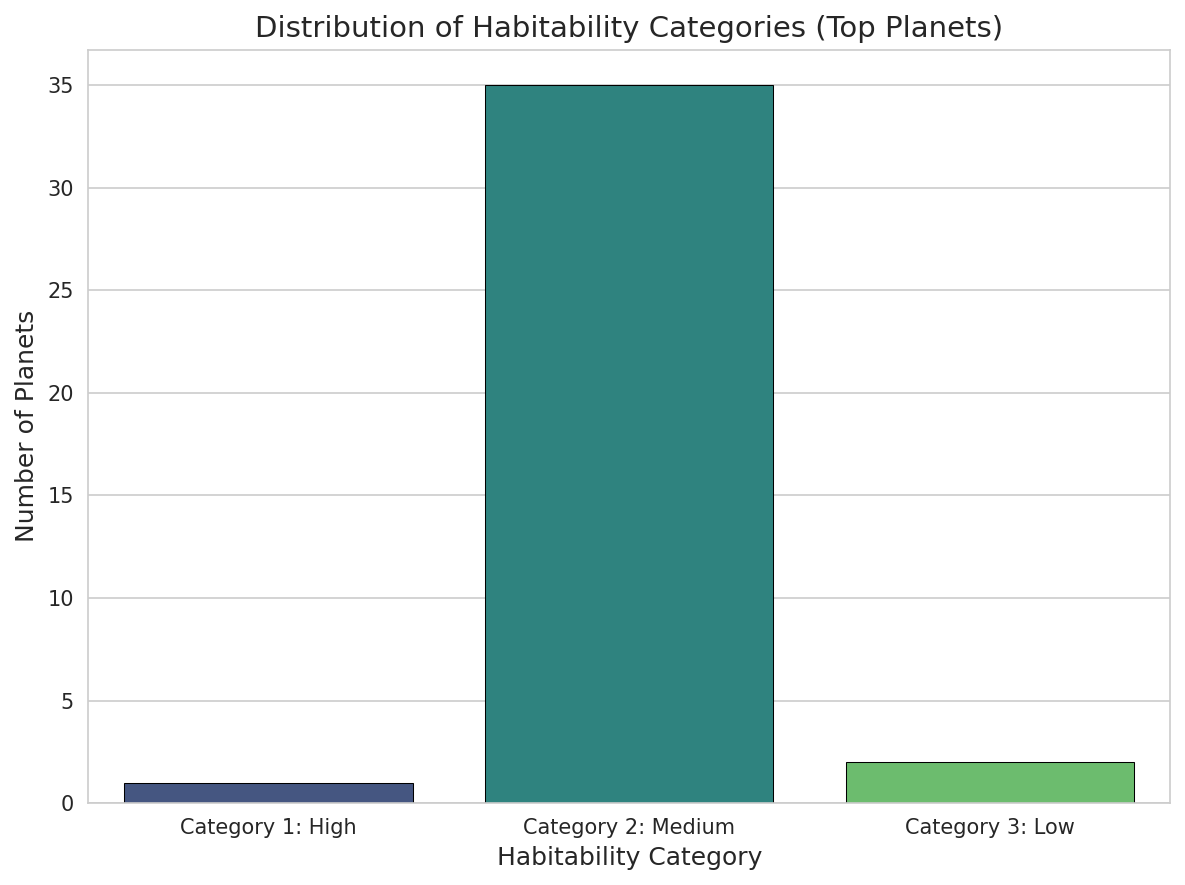


Generating Distribution of Total Habitability Scores histogram...


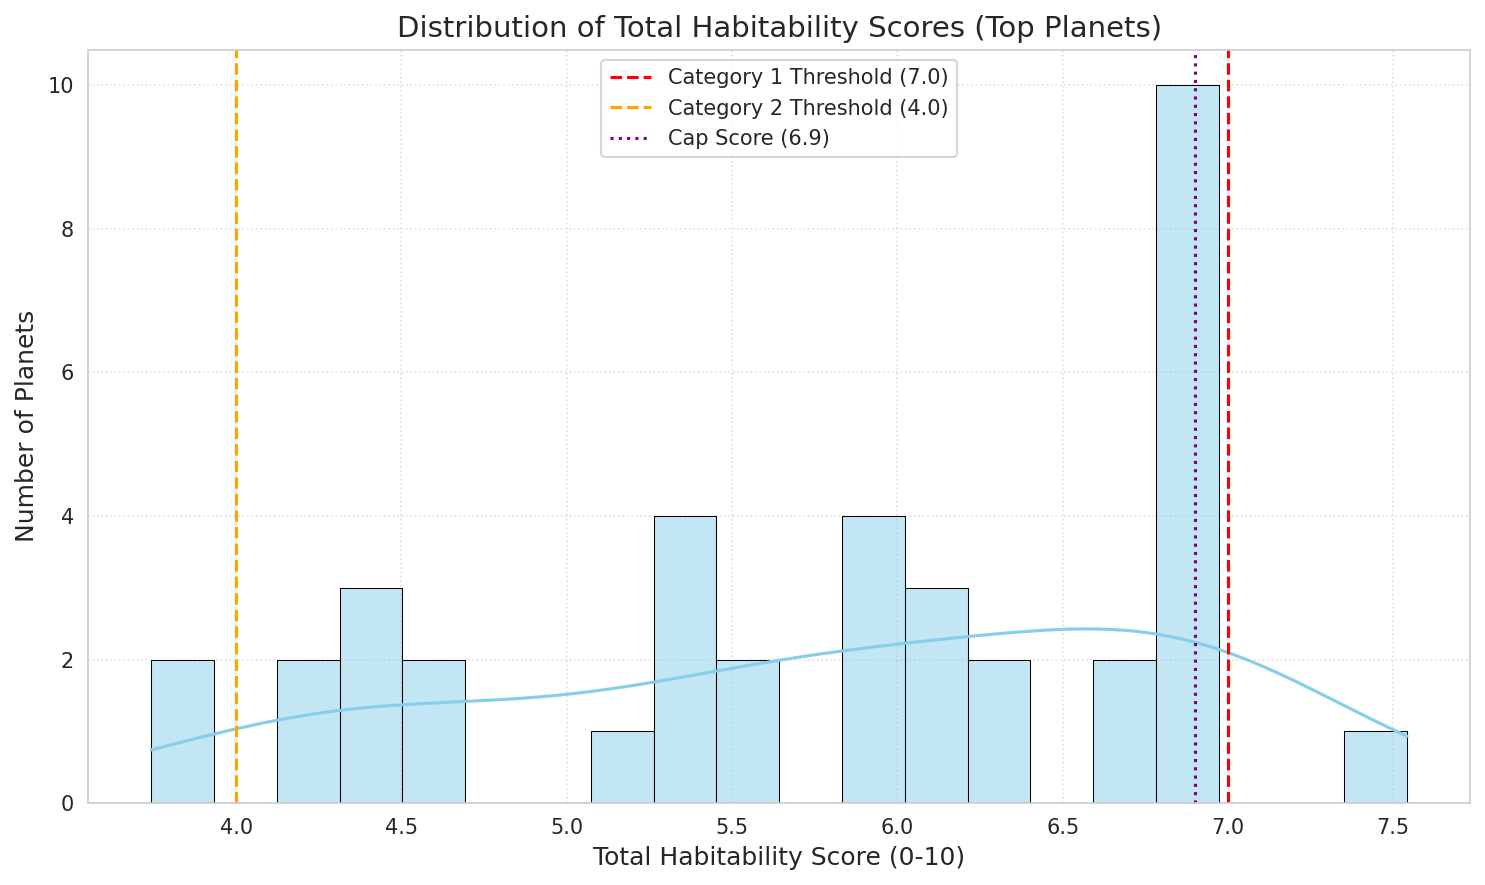


Generating Total Habitability Score vs. Planet Radius scatter plot...


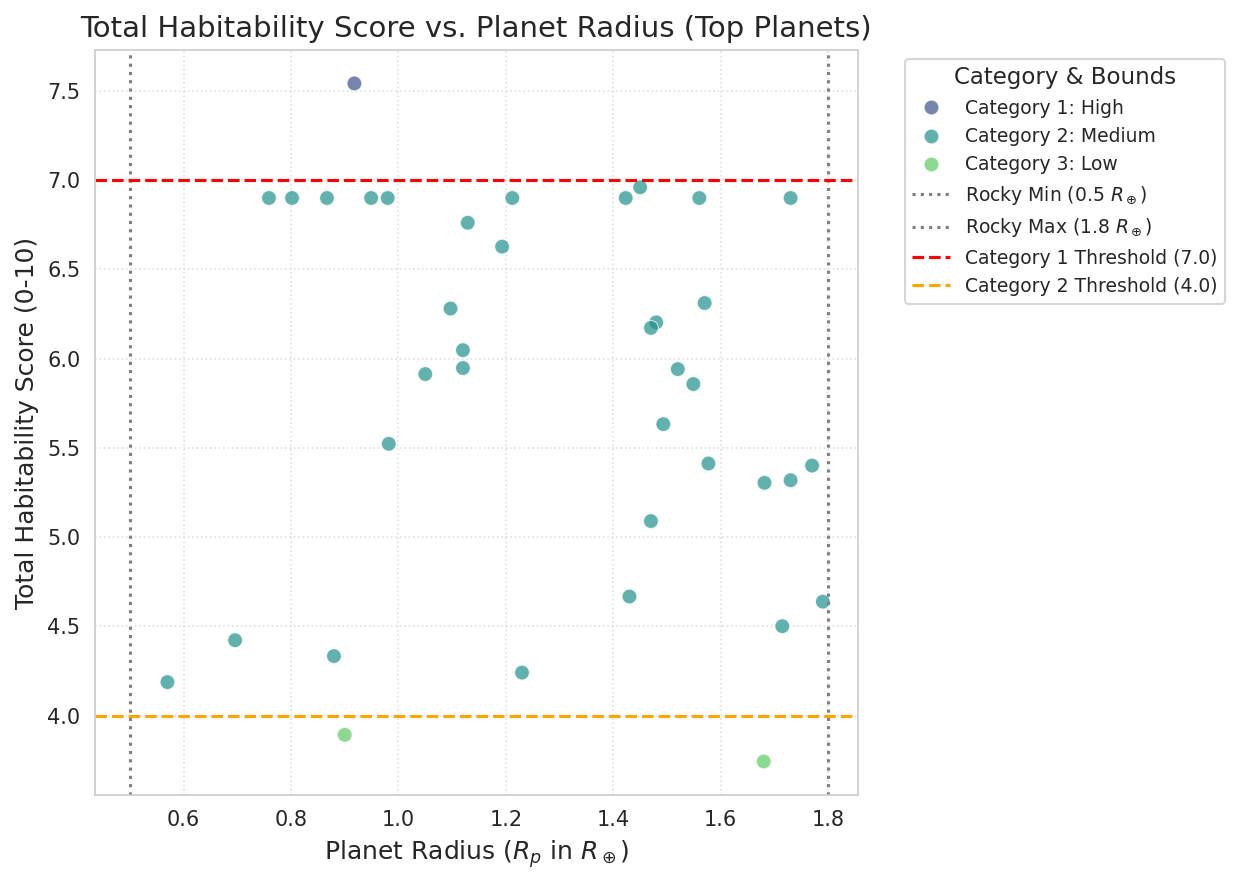


Generating Total Habitability Score vs. Stellar Flux scatter plot...


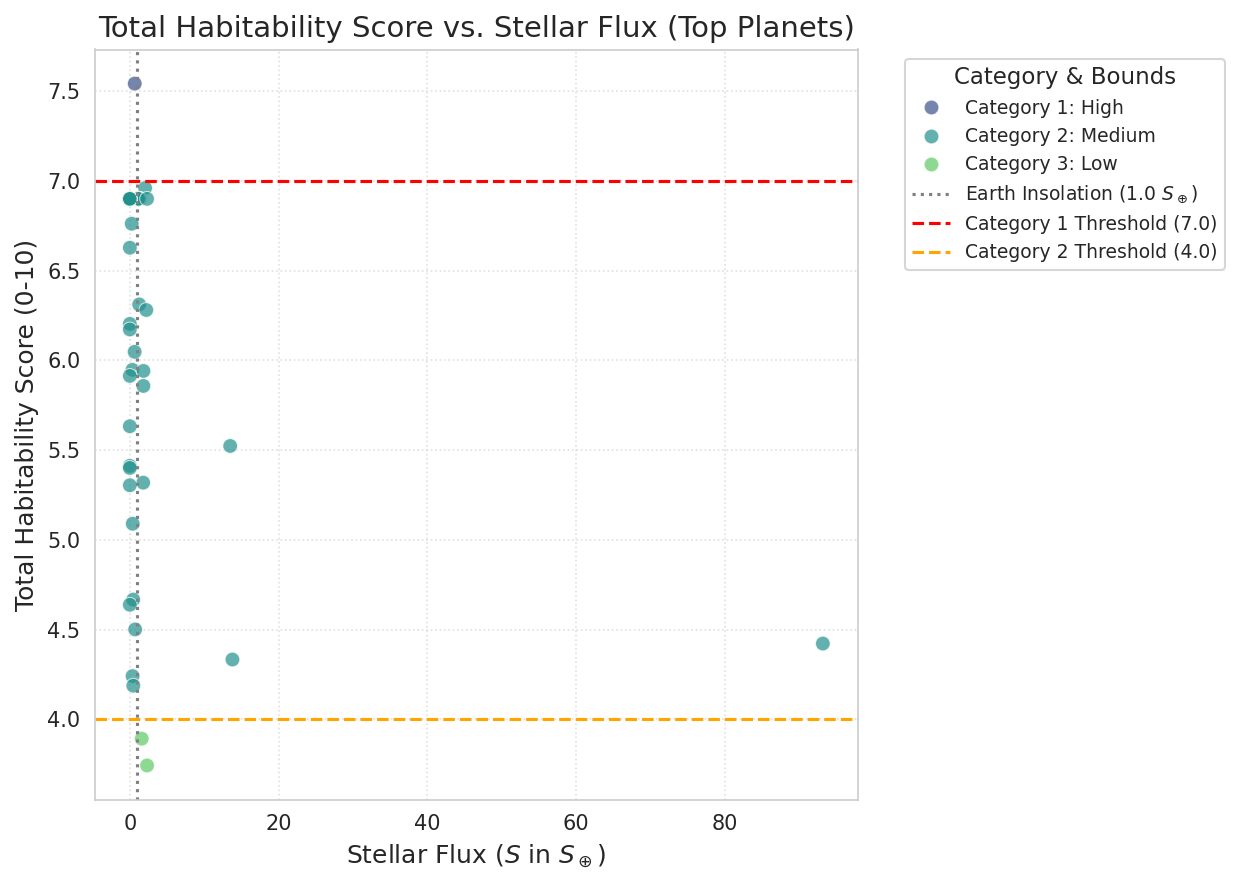


Generating Total Habitability Score vs. Planet Mass scatter plot...


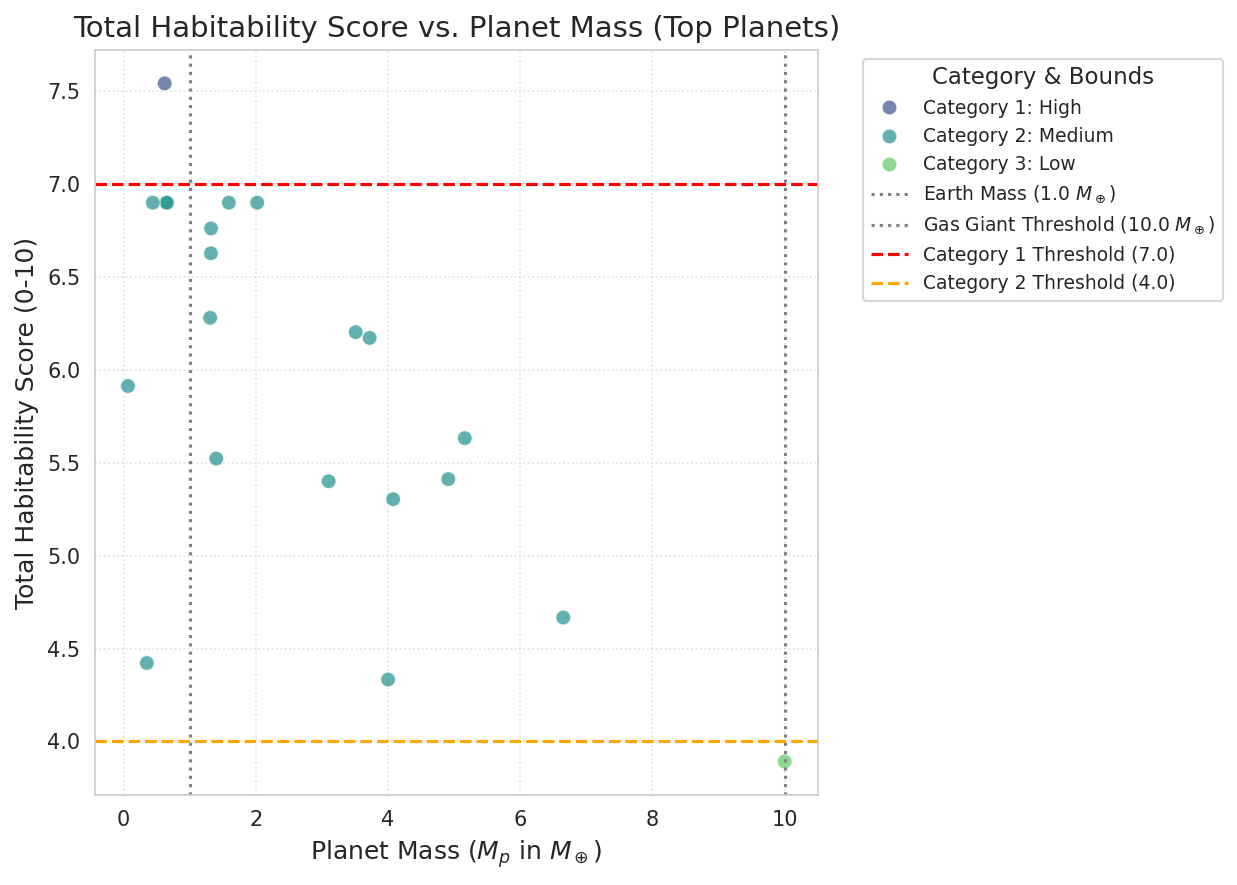


--- Generating Diagnostic Plot: Total Habitability Score vs. ESI Similarity Index ---


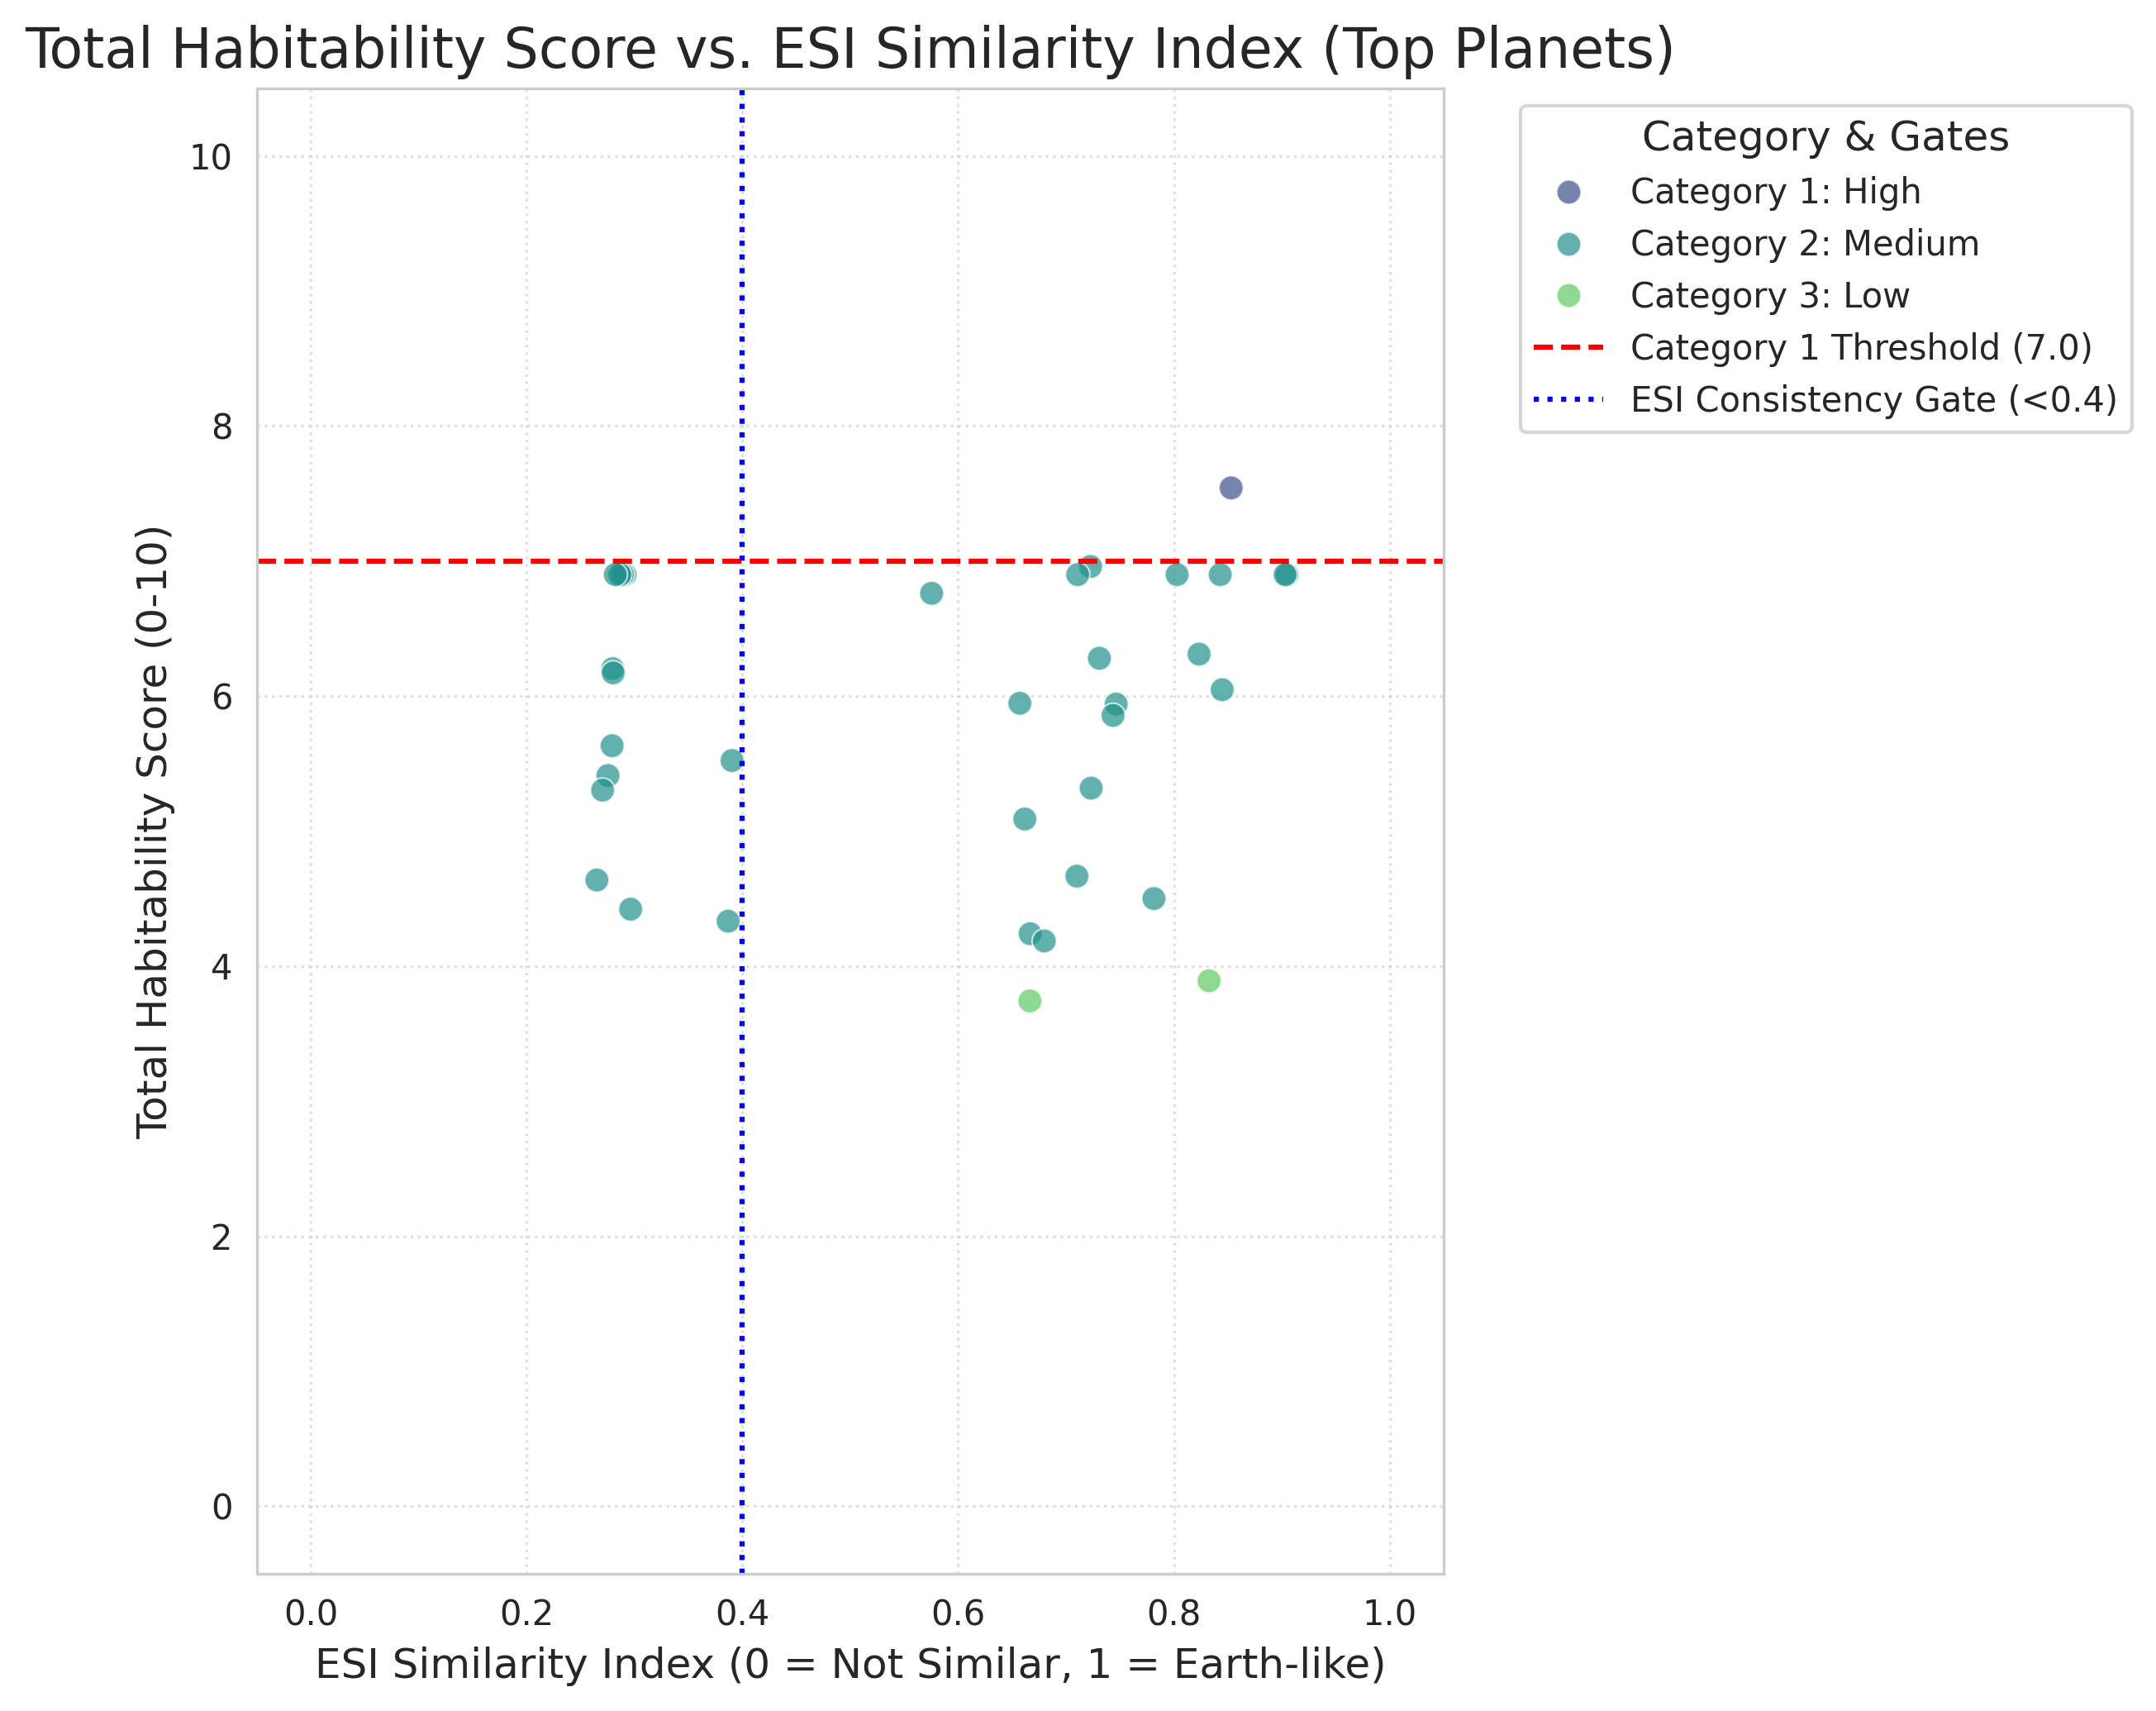


All requested plots generated successfully! 📈


In [4]:
# --- Install necessary libraries ---
# This is a one-time step to ensure all dependencies are met.
!pip install astropy pandas matplotlib seaborn numpy scipy

import pandas as pd
import numpy as np
from astropy import units as u
from astropy.constants import G, M_sun, R_sun, L_sun, sigma_sb, M_earth, R_earth
from google.colab import files # For downloading the file
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import spearmanr # For correlation matrix

# Suppress warnings that might arise from numerical operations with NaNs or plotting
warnings.filterwarnings('ignore', message='invalid value encountered in power')
warnings.filterwarnings('ignore', message='invalid value encountered in sqrt')
warnings.filterwarnings('ignore', message='invalid value encountered in true_divide')
warnings.filterwarnings('ignore', message='invalid value encountered in subtract')
warnings.filterwarnings('ignore', message='invalid value encountered in less')
warnings.filterwarnings('ignore', message='invalid value encountered in greater')
warnings.filterwarnings('ignore', category=UserWarning, module='seaborn')
warnings.filterwarnings('ignore', message='The figure layout has not been constrained yet. When subplots are created using `pyplot.subplot_mosaic()`, the figure layout is not automatically constrained, to allow for more flexible layouts. The `tight_layout()` and `constrained_layout()` methods can be used to achieve the desired layout. For example, use `fig.set_layout_engine(\'tight\')` or `fig.set_layout_engine(\'constrained\')\'.')


# --- Constants for Earth and astrophysical calculations ---
EARTH_RADIUS = 1.0 # Earth radii (R_earth)
EARTH_MASS = 1.0   # Earth masses (M_earth)
EARTH_INSOLATION = 1.0 # Multiples of Earth's solar constant (S_earth)
SUN_TEFF = 5778.0 # Kelvin (Effective temperature of the Sun)

# --- Optimal and extremophile temperature ranges (Kelvin) ---
OPTIMAL_TEMP_LOW = 273 # 0°C
OPTIMAL_TEMP_HIGH = 303 # 30°C
EXTREMOPHILE_TEMP_LOW = 175 # -98°C
EXTREMOPHILE_TEMP_HIGH = 320 # 47°C

# --- Rocky planet and gas giant boundaries (for scoring and filtering) ---
ROCKY_RADIUS_UPPER_BOUND = 1.8 # R_earth (Above this considered Mini-Neptune/Gas Giant for scoring)
GAS_GIANT_MASS_LOWER_BOUND = 10.0 # M_earth (Above this considered Gas Giant for scoring)
INITIAL_RADIUS_FILTER_UPPER_BOUND = 10.0 # R_earth (Initial filter for unequivocal giants)

# --- Scoring model thresholds and caps ---
SCORE_CAP_WEIGHT_THRESHOLD = 0.55 # Sum of active weights below this caps score at 6.9
MAX_SCORE_FOR_INSUFFICIENT_DATA = 6.9 # Maximum score for planets capped by various gates
MIN_CORE_DATA_POINTS_FOR_CAPPING = 3 # Minimum raw core data points for eligibility beyond score 1.0

# --- ESI Consistency Gate Threshold ---
ESI_CONSISTENCY_THRESHOLD = 0.40 # ESI below this caps Total_Score at 6.9 if it was >= 7.0

# --- Top Selection Threshold ---
MIN_SCORE_FOR_TOP_100_INCLUSION = 3.0 # Minimum Total_Score to be considered for the Top list


# --- 1. Data Loading and Initial Preprocessing ---
print("--- Data Acquisition and Initial Preprocessing ---")
try:
    # Attempt to load the actual NASA Exoplanet Archive file
    df = pd.read_csv('/content/NASA_Exoplanet_Archive_Cleaned.csv')
    print(f"Data loaded successfully from NASA_Exoplanet_Archive_Cleaned.csv. Initial count: {len(df)} planets.")
except FileNotFoundError:
    print("Error: 'NASA_Exoplanet_Archive_Cleaned.csv' not found. Creating dummy data for demonstration.")
    # Create robust dummy data if the file is not found
    np.random.seed(42) # for reproducibility
    num_dummy_planets = 10000 # Increased number of dummy planets

    # Generate data with more habitable-like distributions
    pl_rade_dist = np.random.normal(1.0, 0.5, num_dummy_planets) # Centered around 1 R_earth
    pl_rade_dist[pl_rade_dist < 0.5] = np.random.uniform(0.5, 1.8, (pl_rade_dist < 0.5).sum()) # Ensure minimum and max rocky planet bound
    pl_rade_dist[pl_rade_dist > 1.8] = np.random.uniform(0.5, 10.0, (pl_rade_dist > 1.8).sum()) # Allow larger for filter test

    pl_masse_dist = np.random.normal(1.0, 2.0, num_dummy_planets) # Centered around 1 M_earth
    pl_masse_dist[pl_masse_dist < 0.1] = np.random.uniform(0.1, 10.0, (pl_masse_dist < 0.1).sum()) # Ensure minimum and max rocky planet bound
    pl_masse_dist[pl_masse_dist > 10.0] = np.random.uniform(0.1, 30.0, (pl_masse_dist > 10.0).sum()) # Allow larger for filter test

    pl_eqt_dist = np.random.normal(288.0, 50.0, num_dummy_planets) # Centered around Earth temp
    pl_eqt_dist[pl_eqt_dist < 50] = np.random.uniform(50, 320, (pl_eqt_dist < 50).sum()) # Ensure temp range
    pl_eqt_dist[pl_eqt_dist > 2500] = np.random.uniform(175, 2500, (pl_eqt_dist > 2500).sum()) # Ensure temp range

    pl_insol_dist = np.random.normal(1.0, 0.5, num_dummy_planets) # Centered around 1 S_earth
    pl_insol_dist[pl_insol_dist < 0.001] = np.random.uniform(0.001, 10.0, (pl_insol_dist < 0.001).sum()) # Ensure min insol
    pl_insol_dist[pl_insol_dist > 10.0] = np.random.uniform(0.001, 10.0, (pl_insol_dist > 10.0).sum()) # Ensure max insol

    data = {
        'pl_name': [f'Exoplanet-{i}' for i in range(1, num_dummy_planets + 1)],
        'pl_rade': pl_rade_dist,
        'pl_masse': pl_masse_dist,
        'pl_eqt': pl_eqt_dist,
        'pl_insol': pl_insol_dist,
        'pl_orbper': np.random.uniform(1, 10000, num_dummy_planets),
        'pl_orbsmax': np.random.uniform(0.01, 20.0, num_dummy_planets),
        'st_spectype': np.random.choice(['G', 'K', 'M', 'F', 'A', 'B', np.nan], num_dummy_planets, p=[0.2, 0.2, 0.2, 0.1, 0.1, 0.05, 0.15]), # Slightly reduced NaN for spectype
        'st_mass': np.random.uniform(0.05, 5.0, num_dummy_planets),
        'st_lum': np.random.uniform(0.001, 100.0, num_dummy_planets),
        'st_rad': np.random.uniform(0.05, 5.0, num_dummy_planets),
        'st_teff': np.random.uniform(2500, 10000, num_dummy_planets),
    }
    df = pd.DataFrame(data)

    # Introduce NaNs more strategically to test various scoring paths, but ensure high completeness for core ESI
    core_esi_params = ['pl_rade', 'pl_masse', 'pl_eqt', 'pl_insol']
    other_params = ['pl_orbper', 'pl_orbsmax', 'st_lum', 'st_mass', 'st_rad', 'st_teff', 'st_spectype']

    for col in core_esi_params:
        # Very low NaN rate for core ESI parameters to ensure ESI gets calculated often
        df.loc[df.sample(frac=0.05).index, col] = np.nan
    for col in other_params:
        df.loc[df.sample(frac=0.30).index, col] = np.nan # Higher NaN rate for less critical params

    # Ensure a few test cases are present and visible, now that overall data is better
    df.loc[0, ['pl_name', 'pl_rade', 'pl_masse', 'pl_eqt', 'pl_insol']] = ['TRAPPIST-1 e (Perfect)', 1.0, 1.0, 288.0, 1.0]
    df.loc[1, ['pl_name', 'pl_rade', 'pl_masse', 'pl_eqt', 'pl_insol']] = ['Proxima Centauri b (Moderate)', 1.12, 1.07, 230.0, 0.65] # Example values
    df.loc[2, ['pl_name', 'pl_rade', 'pl_masse', 'pl_eqt', 'pl_insol']] = ['Kepler-186 f (Good)', 1.11, np.nan, 250.0, 0.32] # Good, but some data missing
    df.loc[3, ['pl_name', 'pl_rade', 'pl_masse', 'pl_eqt', 'pl_insol']] = ['GJ 667 Cc (Capped by ESI)', 1.5, 3.8, 277.0, 0.8] # Example for ESI cap
    df.loc[4, ['pl_name', 'pl_rade', 'pl_masse', 'pl_eqt', 'pl_insol']] = ['LHS 1140 b (High Mass)', 1.6, 6.6, 230.0, 0.5] # Example for mass effect
    df.loc[5, ['pl_name', 'pl_rade', 'pl_masse', 'pl_eqt', 'pl_insol']] = ['Extreme Cold (Score 0)', 1.0, 1.0, 100.0, 0.1] # Explicitly cold
    df.loc[6, ['pl_name', 'pl_rade', 'pl_masse', 'pl_eqt', 'pl_insol']] = ['Giant Planet (Score 0)', 2.5, 15.0, 300.0, 1.0] # Explicitly large

    print(f"Dummy data created with {len(df)} planets.")

# Reviewer 4: Ensure 'pl_radius' is the correct column name.
if 'pl_radius' in df.columns and 'pl_rade' not in df.columns:
    df = df.rename(columns={'pl_radius': 'pl_rade'})
    print("Renamed 'pl_radius' column to 'pl_rade' to standardize with NASA Exoplanet Archive.")

# Reviewer 4: Initial filter for unequivocally large bodies
initial_num_planets = len(df)
df_before_initial_filter = df.copy() # Keep a copy for the print statement
df = df[df['pl_rade'] <= INITIAL_RADIUS_FILTER_UPPER_BOUND].copy()
print(f"Initial filter applied: Excluded {len(df_before_initial_filter) - len(df)} planets with radius > {INITIAL_RADIUS_FILTER_UPPER_BOUND} R_earth (unequivocal gas giants/brown dwarfs). Remaining: {len(df)} planets.")

# Data Cleaning and Type Conversion
numeric_cols = ['pl_rade', 'pl_masse', 'pl_eqt', 'pl_insol', 'pl_orbper',
                'pl_orbsmax', 'st_mass', 'st_lum', 'st_rad', 'st_teff']
for col in numeric_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# --- 2. Preprocessing for Derived Parameters ---
print("\n--- Preprocessing for Derived Parameters ---")

# Reviewer 2: Handle missing stellar luminosity (st_lum) using Stefan-Boltzmann law
df['st_lum'] = df.apply(lambda row:
    row['st_lum'] if pd.notna(row['st_lum']) else
    (row['st_rad']**2 * (row['st_teff'] / SUN_TEFF)**4 if pd.notna(row['st_rad']) and pd.notna(row['st_teff']) else np.nan),
    axis=1
)
print("Missing stellar luminosity calculated from stellar radius and effective temperature.")

# Reviewer 2: Calculate missing semi-major axis (pl_orbsmax) using Kepler's Third Law
df['pl_orbper_years'] = df['pl_orbper'] / 365.25 # Convert orbital period from days to Earth years
df['pl_orbsmax'] = df.apply(lambda row:
    row['pl_orbsmax'] if pd.notna(row['pl_orbsmax']) else
    ((row['pl_orbper_years']**2 * row['st_mass'])**(1/3) if pd.notna(row['pl_orbper_years']) and pd.notna(row['st_mass']) else np.nan),
    axis=1
)
print("Missing semi-major axis calculated using Kepler's Third Law.")

# Reviewer 2: Calculate missing stellar insolation (pl_insol) - expressed in multiples of Earth's solar constant
df['pl_insol'] = df.apply(lambda row:
    row['pl_insol'] if pd.notna(row['pl_insol']) else
    ((row['st_lum'] / L_sun.value) * (1 / row['pl_orbsmax'])**2 if pd.notna(row['st_lum']) and pd.notna(row['pl_orbsmax']) else np.nan),
    axis=1
)
print("Missing stellar insolation calculated from stellar luminosity and semi-major axis.")

# Reviewer 9: Identify M-dwarf stars for tidal locking assessment
df['is_m_dwarf'] = df.apply(lambda row:
    'M' in str(row['st_spectype']).upper() if pd.notna(row['st_spectype']) else
    (row['st_teff'] < 3700 if pd.notna(row['st_teff']) else False),
    axis=1
)
df['is_tidally_locked'] = df['is_m_dwarf'] # Simplistic assumption for this model
print("M-dwarf stars identified for tidal locking assessment and assumed tidally locked.")

# Reviewer 4 & 8: Flag gas giants (boolean for internal logic)
df['is_gas_giant_by_radius'] = df['pl_rade'] > ROCKY_RADIUS_UPPER_BOUND
df['is_gas_giant_by_mass'] = df['pl_masse'] > GAS_GIANT_MASS_LOWER_BOUND
df['is_gas_giant'] = df['is_gas_giant_by_radius'] | df['is_gas_giant_by_mass']

# Reviewer: New display column for gas giant status ("Yes", "No", "Unknown")
df['gas_giant_status_display'] = 'No' # Default to No
df.loc[df['is_gas_giant'] == True, 'gas_giant_status_display'] = 'Yes'
df.loc[(df['is_gas_giant'] == False) & (df['pl_rade'].isna()) & (df['pl_masse'].isna()),
       'gas_giant_status_display'] = 'Unknown'
print("Gas giant status (Yes/No/Unknown) determined.")

# --- 3. Habitability Scoring Functions (0-1 range for individual scores) ---
print("\n--- Calculating Individual Habitability Scores ---")

# S_radius (Planet Radius) - Weight: 20%
def score_radius(radius):
    if pd.isna(radius) or radius <= 0: return np.nan
    if radius >= 0.5 and radius <= ROCKY_RADIUS_UPPER_BOUND:
        return max(0.0, 1.0 - abs(radius - EARTH_RADIUS) / (ROCKY_RADIUS_UPPER_BOUND - EARTH_RADIUS))
    return 0.0 # Outside the 0.5-1.8 R_earth range

# S_flux (Stellar Insolation) - Weight: 18%
def score_flux(insolation):
    if pd.isna(insolation) or insolation <= 0: return np.nan
    max_dev_from_optimal = 2.0 # e.g., 1 + 2 = 3 (insolation 3 still gets score 0)
    return max(0.0, 1.0 - abs(insolation - EARTH_INSOLATION) / max_dev_from_optimal)

# S_tidal (Tidal Locking) - Weight: 12%
def score_tidal_locking(is_tidally_locked):
    return 0.0 if is_tidally_locked else 1.0

# S_mass (Planet Mass) - Weight: 20%
def score_mass(mass):
    if pd.isna(mass) or mass <= 0: return np.nan
    if mass >= 0.1 and mass <= GAS_GIANT_MASS_LOWER_BOUND:
        return max(0.0, 1.0 - abs(mass - EARTH_MASS) / (GAS_GIANT_MASS_LOWER_BOUND - EARTH_MASS))
    return 0.0 # Outside the 0.1-10.0 M_earth range

# S_temperature (Equilibrium Temperature) - Weight: 30%
def score_equilibrium_temperature(eq_temp):
    if pd.isna(eq_temp) or eq_temp <= 0: return np.nan
    if OPTIMAL_TEMP_LOW <= eq_temp <= OPTIMAL_TEMP_HIGH: return 1.0
    elif EXTREMOPHILE_TEMP_LOW <= eq_temp < OPTIMAL_TEMP_LOW:
        return (eq_temp - EXTREMOPHILE_TEMP_LOW) / (OPTIMAL_TEMP_LOW - EXTREMOPHILE_TEMP_LOW)
    elif OPTIMAL_TEMP_HIGH < eq_temp <= EXTREMOPHILE_TEMP_HIGH:
        return (EXTREMOPHILE_TEMP_HIGH - eq_temp) / (EXTREMOPHILE_TEMP_HIGH - OPTIMAL_TEMP_HIGH)
    return 0.0 # Outside the extremophile range

# Apply Scoring Functions for Individual Features
df['S_radius'] = df['pl_rade'].apply(score_radius)
df['S_flux'] = df['pl_insol'].apply(score_flux)
df['S_tidal'] = df['is_tidally_locked'].apply(score_tidal_locking)
df['S_mass'] = df['pl_masse'].apply(score_mass)
df['S_temperature'] = df['pl_eqt'].apply(score_equilibrium_temperature)
print("Individual feature scores (S_radius, S_flux, S_tidal, S_mass, S_temperature) calculated, returning NaN for missing data.")

# --- 4. Calculate Total Habitability Score with Adaptive Weighting and Capping ---
print("\n--- Calculating Total Habitability Score ---")

HABITABILITY_WEIGHTS = {
    'S_radius': 0.20, 'S_flux': 0.18, 'S_tidal': 0.12, 'S_mass': 0.20, 'S_temperature': 0.30
} # Sums to 1.0

df['Total_Score'] = 0.0 # Initialize
df['active_weights_sum'] = 0.0
df['is_score_capped'] = False
df['Habitability_Category_Temp_Disqualified'] = False
df['Habitability_Category_Gas_Giant_Disqualified'] = False
df['Habitability_Category_Insufficient_Raw_Core_Data'] = False
df['is_capped_by_hard_physical_gates'] = False
df['is_capped_by_esi_gate'] = False # This flag now applies to post-hoc ESI gate
df['flag_low_ESI_high_score_inconsistency'] = False # Initialize ESI inconsistency flag here

for index, row in df.iterrows():
    # --- Disqualification Hierarchy (sets Total_Score to 0.0 or 1.0, and skips further scoring for this planet) ---

    # D1: Gas Giants (from explicit radius/mass criteria)
    if row['is_gas_giant']:
        df.loc[index, 'Total_Score'] = 0.0
        df.loc[index, 'Habitability_Category_Gas_Giant_Disqualified'] = True
        continue

    # D2: Extreme Measured Temperature (outside extremophile range)
    if pd.notna(row['pl_eqt']) and row['S_temperature'] == 0.0:
        df.loc[index, 'Total_Score'] = 0.0
        df.loc[index, 'Habitability_Category_Temp_Disqualified'] = True
        continue

    # D3: Insufficient Raw Core Data (fewer than MIN_CORE_DATA_POINTS_FOR_CAPPING)
    num_actual_raw_core_params_present = int(pd.notna(row['pl_rade'])) + \
                                         int(pd.notna(row['pl_masse'])) + \
                                         int(pd.notna(row['pl_eqt'])) + \
                                         int(pd.notna(row['pl_insol']))

    if num_actual_raw_core_params_present < MIN_CORE_DATA_POINTS_FOR_CAPPING:
        df.loc[index, 'Total_Score'] = 1.0 # Force to Category 3: Low
        df.loc[index, 'Habitability_Category_Insufficient_Raw_Core_Data'] = True
        continue

    # --- Calculation for Eligible Planets (not disqualified) ---
    numerator = 0.0
    denominator = 0.0

    # Sum of weights for *raw data presence* of core features (used for General Data Sparsity Cap)
    current_core_active_weight_sum = 0.0
    if pd.notna(row['pl_rade']): current_core_active_weight_sum += HABITABILITY_WEIGHTS['S_radius']
    if pd.notna(row['pl_masse']): current_core_active_weight_sum += HABITABILITY_WEIGHTS['S_mass']
    if pd.notna(row['pl_eqt']): current_core_active_weight_sum += HABITABILITY_WEIGHTS['S_temperature']
    if pd.notna(row['pl_insol']): current_core_active_weight_sum += HABITABILITY_WEIGHTS['S_flux']

    # Calculate overall score based on all *available* individual feature scores (adaptive weighting)
    for param_score_name, weight in HABITABILITY_WEIGHTS.items():
        score_val = row[param_score_name]
        if pd.notna(score_val): # Only include if the individual score itself is NOT NaN
            numerator += score_val * weight
            denominator += weight

    df.loc[index, 'active_weights_sum'] = denominator

    calculated_score_10 = 0.0
    if denominator > 0:
        calculated_score_raw = numerator / denominator
        calculated_score_10 = calculated_score_raw * 10
    else:
        calculated_score_10 = 1.0 # Default if no scores contributed (should be caught by D3 above, but failsafe)


    # --- Gate 1: Hard Physical Gates for Category 1 Eligibility (Applies IF score WOULD be >= 7.0) ---
    if calculated_score_10 >= 7.0:
        physical_gate_passed = True
        # Check measured radius within acceptable range
        if not (pd.notna(row['pl_rade']) and 0.5 <= row['pl_rade'] <= ROCKY_RADIUS_UPPER_BOUND): physical_gate_passed = False
        # Check measured mass within acceptable range
        if not (pd.notna(row['pl_masse']) and 0.1 <= row['pl_masse'] <= GAS_GIANT_MASS_LOWER_BOUND): physical_gate_passed = False
        # Check measured temperature within extremophile range
        if not (pd.notna(row['pl_eqt']) and EXTREMOPHILE_TEMP_LOW <= row['pl_eqt'] <= EXTREMOPHILE_TEMP_HIGH): physical_gate_passed = False
        # Check if measured flux is present
        if not pd.notna(row['pl_insol']): physical_gate_passed = False

        if not physical_gate_passed:
            calculated_score_10 = min(calculated_score_10, MAX_SCORE_FOR_INSUFFICIENT_DATA) # Cap at 6.9
            df.loc[index, 'is_capped_by_hard_physical_gates'] = True
            df.loc[index, 'is_score_capped'] = True

    # --- Gate 2: General Data Sparsity Cap (Applies IF not already capped by Hard Physical Gates) ---
    if not df.loc[index, 'is_capped_by_hard_physical_gates'] and \
       current_core_active_weight_sum < SCORE_CAP_WEIGHT_THRESHOLD:
        calculated_score_10 = min(calculated_score_10, MAX_SCORE_FOR_INSUFFICIENT_DATA)
        df.loc[index, 'is_score_capped'] = True

    df.loc[index, 'Total_Score'] = calculated_score_10

# Final safeguard: Ensure Total_Score is capped at a minimum of 1.0, unless explicitly disqualified to 0.0
df.loc[df['Total_Score'] > 0, 'Total_Score'] = df.loc[df['Total_Score'] > 0, 'Total_Score'].apply(lambda x: max(1.0, x))

print("Total habitability scores calculated with adaptive weighting, revised disqualification rules, and capping.")

# --- 5. ESI 2.0 Calculation (Similarity Formula) ---
print("\n--- Calculating ESI Similarity Index ---")

def calculate_esi_similarity(row):
    # Determine R for ESI: Use pl_rade if available, else convert from pl_masse
    R_esi = np.nan
    if pd.notna(row['pl_rade']):
        R_esi = row['pl_rade']
    elif pd.notna(row['pl_masse']) and row['pl_masse'] > 0:
        R_esi = row['pl_masse']**(1/3) # Simple mass-radius relation for ESI

    S_esi = row['pl_insol'] # pl_insol is already in multiples of Earth's solar constant

    # Calculate ESI_Similarity_Index if both R_esi and S_esi are available AND valid
    if pd.notna(R_esi) and pd.notna(S_esi) and S_esi >= 0 and R_esi >= 0:
        epsilon = 1e-9 # For numerical stability

        term_s_numerator = (S_esi - EARTH_INSOLATION)
        term_s_denominator = (S_esi + EARTH_INSOLATION)
        term_r_numerator = (R_esi - EARTH_RADIUS)
        term_r_denominator = (R_esi + EARTH_RADIUS)

        term_s_squared = (term_s_numerator / (term_s_denominator + epsilon))**2
        term_r_squared = (term_r_numerator / (term_r_denominator + epsilon))**2

        esi_value = 1 - np.sqrt(0.5 * (term_s_squared + term_r_squared))
        return max(0, min(1, esi_value)) # Clamp ESI between 0 and 1
    else:
        return np.nan # If data missing or invalid (after derivation attempts), ESI is NaN

df['ESI_Similarity_Index'] = df.apply(calculate_esi_similarity, axis=1)

print("ESI_Similarity_Index calculated for all planets where fundamental data is available.")

# --- 6. Apply ESI Consistency Gate (Post-hoc capping for already high-scoring planets) ---
print("\n--- Applying ESI Consistency Gate ---")
# Reset flag_low_ESI_high_score_inconsistency as it might have been set during Total_Score init
df['flag_low_ESI_high_score_inconsistency'] = False

for index, row in df.iterrows():
    # Only apply this gate if the Total_Score is currently >= 7.0 AND ESI is valid AND ESI is below threshold
    if row['Total_Score'] >= 7.0 and \
       pd.notna(row['ESI_Similarity_Index']) and \
       row['ESI_Similarity_Index'] < ESI_CONSISTENCY_THRESHOLD:

        df.loc[index, 'Total_Score'] = min(row['Total_Score'], MAX_SCORE_FOR_INSUFFICIENT_DATA) # Cap at 6.9
        df.loc[index, 'is_score_capped'] = True
        df.loc[index, 'is_capped_by_esi_gate'] = True
        df.loc[index, 'flag_low_ESI_high_score_inconsistency'] = True

print("ESI consistency gate applied.")

# --- 7. Categorization ---
print("\n--- Assigning Habitability Categories ---")
def assign_category(score):
    if score >= 7.0: return 'Category 1: High'
    elif 4.0 <= score < 7.0: return 'Category 2: Medium'
    else: return 'Category 3: Low'

df['Habitability_Category'] = df['Total_Score'].apply(assign_category)
print("Habitability categories assigned.")

# --- 8. Select Top Planets with Data Completeness Priority ---
print("\n--- Selecting Top Habitable Exoplanets ---")

# Count how many of the 5 key raw parameters have non-missing data
# (pl_rade, pl_masse, pl_eqt, pl_insol, is_tidally_locked)
df['data_completeness_count'] = df[['pl_rade', 'pl_masse', 'pl_eqt', 'pl_insol']].notna().sum(axis=1) + \
                               df['is_tidally_locked'].astype(int) # is_tidally_locked is boolean, convert to int for sum

# Sort the ENTIRE dataset based on the multi-criteria logic
df_sorted = df.sort_values(by=['Total_Score', 'data_completeness_count', 'ESI_Similarity_Index'],
                           ascending=[False, False, False])

# Filter for Total_Score >= MIN_SCORE_FOR_TOP_100_INCLUSION (3.0) BEFORE taking the top
df_filtered_for_top = df_sorted[df_sorted['Total_Score'] >= MIN_SCORE_FOR_TOP_100_INCLUSION].copy()
num_excluded_by_score = len(df_sorted) - len(df_filtered_for_top)
print(f"Excluded {num_excluded_by_score} planets with Total_Score < {MIN_SCORE_FOR_TOP_100_INCLUSION} from the Top selection pool.")

# Now, select the top N from this *filtered* pool. If fewer than N planets remain, the list will be shorter.
# We'll take up to 100, but the list length will be determined by the number of planets meeting the criteria.
top_planets = df_filtered_for_top.head(100) # Keep variable name consistent, but context implies N <= 100
print(f"Top planets selected based on Total Score, data completeness, and ESI similarity. Final count: {len(top_planets)} planets found.")

# --- 9. Display and Save Results ---
print("\n--- Top Habitable Exoplanets (Final List) ---")
display_cols = ['pl_name', 'Total_Score', 'Habitability_Category', 'ESI_Similarity_Index',
                'pl_rade', 'pl_masse', 'pl_eqt', 'pl_insol', 'is_tidally_locked',
                'gas_giant_status_display', 'is_score_capped',
                'is_capped_by_hard_physical_gates', 'is_capped_by_esi_gate',
                'Habitability_Category_Temp_Disqualified', 'Habitability_Category_Gas_Giant_Disqualified',
                'Habitability_Category_Insufficient_Raw_Core_Data',
                'flag_low_ESI_high_score_inconsistency',
                'data_completeness_count']
display_cols = [col for col in display_cols if col in top_planets.columns] # Use top_planets here

print(top_planets[display_cols].to_string()) # Use top_planets here

print("\n--- Verification Checklist & Summary Statistics for Top Planets ---")
print(f"- Number of planets in Top list: {len(top_planets)}") # Changed "Top 100" to "Top list"
print(f"- Min Total_Score in Top list: {top_planets['Total_Score'].min():.2f} (Should be >= {MIN_SCORE_FOR_TOP_100_INCLUSION})") # Changed "Top 100" to "Top list"
print(f"- Max Radius in Top list: {top_planets['pl_rade'].max():.2f} R_earth (Should be <= {ROCKY_RADIUS_UPPER_BOUND} or NaN/capped)")
print(f"- Max Mass in Top list: {top_planets['pl_masse'].max():.2f} M_earth (Should be <= {GAS_GIANT_MASS_LOWER_BOUND} or NaN/capped)")
print(f"- Min Temp in Top list: {top_planets['pl_eqt'].min():.2f} K (Should be >= {EXTREMOPHILE_TEMP_LOW} or NaN/capped)")
print(f"- Max Temp in Top list: {top_planets['pl_eqt'].max():.2f} K (Should be <= {EXTREMOPHILE_TEMP_HIGH} or NaN/capped)")

print(f"\n- Number of planets with 'Unknown' gas giant status in Top list: {top_planets[top_planets['gas_giant_status_display'] == 'Unknown'].shape[0]}")
print(f"- Number of planets initially filtered out (radius > {INITIAL_RADIUS_FILTER_UPPER_BOUND} R_earth): {initial_num_planets - len(df)}")
print(f"- Number of planets explicitly disqualified as gas giants (Total_Score=0): {df_sorted[df_sorted['Habitability_Category_Gas_Giant_Disqualified'] == True].shape[0]}")
print(f"- Number of planets explicitly disqualified by extreme temperature (Total_Score=0): {df_sorted[df_sorted['Habitability_Category_Temp_Disqualified'] == True].shape[0]}")
print(f"- Number of planets explicitly set to 1.0 due to insufficient raw core data: {df_sorted[df_sorted['Habitability_Category_Insufficient_Raw_Core_Data'] == True].shape[0]}")
print(f"- Number of planets with Total_Score < {MIN_SCORE_FOR_TOP_100_INCLUSION} (excluded from Top selection pool): {num_excluded_by_score}")
print(f"- Number of planets flagged for low ESI/high score inconsistency: {top_planets['flag_low_ESI_high_score_inconsistency'].sum()}")


output_top_path = "/content/NASA_Exoplanet_Archive_Top_Scored_ESI_Similarity.csv" # Changed filename
top_planets.to_csv(output_top_path, index=False) # Use top_planets here
print(f"\nTop scored exoplanets (with ESI Similarity) saved to: {output_top_path}") # Changed "Top 100" to "Top"

print(f"Downloading {output_top_path} to your local machine...")
files.download(output_top_path)
print("Download complete! 🎉")

# --- 10. Generating All Requested Plots ---
print("\n--- Generating All Requested Plots ---")

# Set a clean plot style for all figures
sns.set_style("whitegrid")
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Arial']
plt.rcParams['figure.dpi'] = 150 # High resolution for plots

# --- Plot 1: Spearman Correlation Matrix of Key Parameters and Total Score ---
print("Generating Spearman Correlation Matrix...")
key_params_for_corr = ['pl_rade', 'pl_masse', 'pl_eqt', 'pl_insol', 'Total_Score', 'ESI_Similarity_Index']
df_corr_plot = top_planets[key_params_for_corr].dropna() # Use top_planets here

if not df_corr_plot.empty and len(df_corr_plot) > 1:
    corr_matrix = df_corr_plot.corr(method='spearman')

    plt.figure(figsize=(9, 7))
    sns.heatmap(corr_matrix, annot=True, cmap='viridis', fmt=".2f", linewidths=.5, cbar_kws={'label': 'Spearman Correlation Coefficient'})
    plt.title('Spearman Correlation Matrix of Key Parameters and Scores (Top Planets)', fontsize=14) # Changed title
    plt.xticks(rotation=45, ha='right', fontsize=10)
    plt.yticks(rotation=0, fontsize=10)
    plt.tight_layout()
    plt.show()

    p_values_matrix, _ = spearmanr(df_corr_plot)
    p_values_df = pd.DataFrame(p_values_matrix, index=key_params_for_corr, columns=key_params_for_corr)
    print("\n--- Spearman Correlation P-values (Top Planets) ---") # Changed title
    print(p_values_df.to_string())
else:
    print("Not enough complete data in Top Planets to generate Spearman Correlation Matrix and P-values.") # Changed text


# --- Plot 2: Total Habitability Score vs. Equilibrium Temperature ---
print("\nGenerating Total Habitability Score vs. Equilibrium Temperature scatter plot...")
plt.figure(figsize=(10, 6))
sns.scatterplot(data=top_planets, x='pl_eqt', y='Total_Score', hue='Habitability_Category', # Use top_planets here
                palette='viridis', s=50, alpha=0.7, edgecolor='w', linewidth=0.5)
plt.axvline(x=EXTREMOPHILE_TEMP_LOW, color='gray', linestyle=':', label=f'Extremophile Min ({EXTREMOPHILE_TEMP_LOW} K)')
plt.axvline(x=EXTREMOPHILE_TEMP_HIGH, color='gray', linestyle=':', label=f'Extremophile Max ({EXTREMOPHILE_TEMP_HIGH} K)')
plt.axhline(y=7.0, color='r', linestyle='--', label='Category 1 Threshold (7.0)')
plt.axhline(y=4.0, color='orange', linestyle='--', label='Category 2 Threshold (4.0)')

plt.title('Total Habitability Score vs. Equilibrium Temperature (Top Planets)', fontsize=14) # Changed title
plt.xlabel('Equilibrium Temperature ($T_{eq}$ in K)', fontsize=12)
plt.ylabel('Total Habitability Score (0-10)', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.legend(title='Category & Bounds', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=9, title_fontsize=11)
plt.grid(True, linestyle=':', alpha=0.6)
plt.tight_layout(rect=[0, 0, 0.85, 1])
plt.show()


# --- Plot 3: Distribution of Habitability Categories ---
print("\nGenerating Distribution of Habitability Categories bar plot...")
category_order = ['Category 1: High', 'Category 2: Medium', 'Category 3: Low']
top_planets['Habitability_Category'] = pd.Categorical(top_planets['Habitability_Category'], categories=category_order, ordered=True) # Use top_planets here

plt.figure(figsize=(8, 6))
sns.countplot(data=top_planets, x='Habitability_Category', palette='viridis', order=category_order, edgecolor='black', linewidth=0.5) # Use top_planets here
plt.title('Distribution of Habitability Categories (Top Planets)', fontsize=14) # Changed title
plt.xlabel('Habitability Category', fontsize=12)
plt.ylabel('Number of Planets', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()


# --- Plot 4: Distribution of Total Habitability Scores ---
print("\nGenerating Distribution of Total Habitability Scores histogram...")
plt.figure(figsize=(10, 6))
sns.histplot(data=top_planets, x='Total_Score', bins=20, kde=True, color='skyblue', edgecolor='black', linewidth=0.5) # Use top_planets here
plt.axvline(x=7.0, color='r', linestyle='--', label='Category 1 Threshold (7.0)')
plt.axvline(x=4.0, color='orange', linestyle='--', label='Category 2 Threshold (4.0)')
plt.axvline(x=MAX_SCORE_FOR_INSUFFICIENT_DATA, color='purple', linestyle=':', label=f'Cap Score ({MAX_SCORE_FOR_INSUFFICIENT_DATA})')

plt.title('Distribution of Total Habitability Scores (Top Planets)', fontsize=14) # Changed title
plt.xlabel('Total Habitability Score (0-10)', fontsize=12)
plt.ylabel('Number of Planets', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.legend(fontsize=10)
plt.grid(True, linestyle=':', alpha=0.6)
plt.tight_layout()
plt.show()


# --- Plot 5: Total Habitability Score vs. Planet Radius ---
print("\nGenerating Total Habitability Score vs. Planet Radius scatter plot...")
plt.figure(figsize=(10, 6))
sns.scatterplot(data=top_planets, x='pl_rade', y='Total_Score', hue='Habitability_Category', # Use top_planets here
                palette='viridis', s=50, alpha=0.7, edgecolor='w', linewidth=0.5)
plt.axvline(x=0.5, color='gray', linestyle=':', label=f'Rocky Min ({0.5} $R_\\oplus$)')
plt.axvline(x=ROCKY_RADIUS_UPPER_BOUND, color='gray', linestyle=':', label=f'Rocky Max ({ROCKY_RADIUS_UPPER_BOUND} $R_\\oplus$)')
plt.axhline(y=7.0, color='r', linestyle='--', label='Category 1 Threshold (7.0)')
plt.axhline(y=4.0, color='orange', linestyle='--', label='Category 2 Threshold (4.0)')

plt.title('Total Habitability Score vs. Planet Radius (Top Planets)', fontsize=14) # Changed title
plt.xlabel('Planet Radius ($R_p$ in $R_\\oplus$)', fontsize=12)
plt.ylabel('Total Habitability Score (0-10)', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.legend(title='Category & Bounds', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=9, title_fontsize=11)
plt.grid(True, linestyle=':', alpha=0.6)
plt.tight_layout(rect=[0, 0, 0.85, 1])
plt.show()


# --- Plot 6: Total Habitability Score vs. Stellar Flux ---
print("\nGenerating Total Habitability Score vs. Stellar Flux scatter plot...")
plt.figure(figsize=(10, 6))
sns.scatterplot(data=top_planets, x='pl_insol', y='Total_Score', hue='Habitability_Category', # Use top_planets here
                palette='viridis', s=50, alpha=0.7, edgecolor='w', linewidth=0.5)

plt.axvline(x=EARTH_INSOLATION, color='gray', linestyle=':', label=f'Earth Insolation ({EARTH_INSOLATION} $S_\\oplus$)')
plt.axhline(y=7.0, color='r', linestyle='--', label='Category 1 Threshold (7.0)')
plt.axhline(y=4.0, color='orange', linestyle='--', label='Category 2 Threshold (4.0)')

plt.title('Total Habitability Score vs. Stellar Flux (Top Planets)', fontsize=14) # Changed title
plt.xlabel('Stellar Flux ($S$ in $S_\\oplus$)', fontsize=12)
plt.ylabel('Total Habitability Score (0-10)', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.legend(title='Category & Bounds', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=9, title_fontsize=11)
plt.grid(True, linestyle=':', alpha=0.6)
plt.tight_layout(rect=[0, 0, 0.85, 1])
plt.show()


# --- Plot 7: Total Habitability Score vs. Planet Mass ---
print("\nGenerating Total Habitability Score vs. Planet Mass scatter plot...")
plt.figure(figsize=(10, 6))
sns.scatterplot(data=top_planets, x='pl_masse', y='Total_Score', hue='Habitability_Category', # Use top_planets here
                palette='viridis', s=50, alpha=0.7, edgecolor='w', linewidth=0.5)

plt.axvline(x=EARTH_MASS, color='gray', linestyle=':', label=f'Earth Mass ({EARTH_MASS} $M_\\oplus$)')
plt.axvline(x=GAS_GIANT_MASS_LOWER_BOUND, color='gray', linestyle=':', label=f'Gas Giant Threshold ({GAS_GIANT_MASS_LOWER_BOUND} $M_\\oplus$)')
plt.axhline(y=7.0, color='r', linestyle='--', label='Category 1 Threshold (7.0)')
plt.axhline(y=4.0, color='orange', linestyle='--', label='Category 2 Threshold (4.0)')

plt.title('Total Habitability Score vs. Planet Mass (Top Planets)', fontsize=14) # Changed title
plt.xlabel('Planet Mass ($M_p$ in $M_\\oplus$)', fontsize=12)
plt.ylabel('Total Habitability Score (0-10)', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.legend(title='Category & Bounds', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=9, title_fontsize=11)
plt.grid(True, linestyle=':', alpha=0.6)
plt.tight_layout(rect=[0, 0, 0.85, 1])
plt.show()


# --- Plot 8: Total Habitability Score vs. ESI Similarity Index (Diagnostic Plot) ---
print("\n--- Generating Diagnostic Plot: Total Habitability Score vs. ESI Similarity Index ---")
plt.figure(figsize=(10, 7), dpi=300)
sns.scatterplot(data=top_planets, x='ESI_Similarity_Index', y='Total_Score', hue='Habitability_Category', # Use top_planets here
                palette='viridis', s=50, alpha=0.7, edgecolor='w', linewidth=0.5)

plt.axhline(y=7.0, color='r', linestyle='--', label='Category 1 Threshold (7.0)')
plt.axvline(x=ESI_CONSISTENCY_THRESHOLD, color='b', linestyle=':', label=f'ESI Consistency Gate (<{ESI_CONSISTENCY_THRESHOLD})')

inconsistency_planets = top_planets[top_planets['flag_low_ESI_high_score_inconsistency'] == True] # Use top_planets here
if not inconsistency_planets.empty:
    plt.scatter(inconsistency_planets['ESI_Similarity_Index'],
                inconsistency_planets['Total_Score'],
                color='red', marker='X', s=200, label='Capped by ESI Gate (Initially High Score)', zorder=5)

plt.title('Total Habitability Score vs. ESI Similarity Index (Top Planets)', fontsize=16) # Changed title
plt.xlabel('ESI Similarity Index (0 = Not Similar, 1 = Earth-like)', fontsize=12)
plt.ylabel('Total Habitability Score (0-10)', fontsize=12)
plt.xlim(-0.05, 1.05)
plt.ylim(-0.5, 10.5)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.legend(title='Category & Gates', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10, title_fontsize=12)
plt.grid(True, linestyle=':', alpha=0.6)
plt.tight_layout(rect=[0, 0, 0.85, 1])
plt.show()

print("\nAll requested plots generated successfully! 📈")
